In [2]:
youtube_data = pd.read_pickle("youtube_captions_scraped_filterChannels.pickle")

In [1]:
from nltk.tokenize import word_tokenize # or use some other tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn import svm, datasets, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from datetime import date

import string
import random
import nltk
import pickle
import itertools


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




def document_features(document, word_features):
    document_words = stem_and_tokenize([document])
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

def stem_and_tokenize(document_words):
    ps = PorterStemmer()
    stop = stopwords.words('english') + list(string.punctuation)
    
    tokens = []
    
    ## remove stop words and tokenize
    for sentence in document_words:
        tokens.append([i for i in word_tokenize(sentence.lower()) if i not in stop])
    
    ## flatten word list
    words = [y for x in tokens for y in x]
    
    ## remove numbers and special characters
    words = [word for word in words if word.isalpha()]
    
    ## stem words
    stemmed_words = [ps.stem(w) for w in words]
    
    return stemmed_words
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
sample_size = 250
not_spon = [index for index, item in enumerate(youtube_data.sponsored) if item == 'no']
not_spon_sample = random.sample(not_spon,sample_size)
spon = [index for index, item in enumerate(youtube_data.sponsored) if item == 'yes']
spon_sample = random.sample(spon,sample_size)

In [4]:
train = youtube_data.iloc[not_spon_sample + spon_sample, :]
print(len(train))
train.head()

500


,captions,sponsored,video_ids,channels
57,in today's video I'm going to be vlogging it's...,no,JzQEy822kBU,Needle Media
38,my question that I'm posing to myself and I'm ...,no,5bbgvABAFJ8,Jen Luvs Reviews
291,hey everyone its Ashlee um and today I have a ...,no,EdPFF1zD-v4,Ashley Awesome Artist
148,hey guys welcome back so today I'm doing somet...,no,-3k0PlaJH2s,Joso Anani
124,[Music] [Music] hey what's up my name is Luke ...,no,MUCoV8gdJYM,TwinSauce


In [61]:


spon_test =  list(set(spon) - set(spon_sample))
not_spon_test =  list(set(not_spon) - set(not_spon_sample))


In [62]:
len(spon_test), len(not_spon_test)

(189, 33)

In [66]:
sample_size_test = 30

not_spon_sample = random.sample(not_spon_test,sample_size_test)
spon_sample = random.sample(spon_test,sample_size_test)

test = youtube_data.iloc[not_spon_sample+ spon_sample, :]

In [67]:
len(test)

60

# tokenized features Naive Bayes

In [6]:
all_words = nltk.FreqDist(stem_and_tokenize(train.captions))
word_features = list(all_words)

In [7]:
word_features[:10]

['today',
 'video',
 'go',
 'vlog',
 'sinc',
 'done',
 'one',
 'probabl',
 'low',
 'rescu']

In [8]:
len(word_features)

14920

In [9]:
stem_and_tokenize([train.captions.iloc[0]])[:10] #input must be list!!!!!

['today',
 'video',
 'go',
 'vlog',
 'sinc',
 'done',
 'one',
 'probabl',
 'low',
 'rescu']

In [10]:
filename = 'dictionary_scrape_stemmed.sav'
pickle.dump(word_features, open(filename, 'wb'))

In [11]:
i = 0
document_features(train.captions.iloc[i],
                      word_features)

{'contains(today)': True,
 'contains(video)': True,
 'contains(go)': True,
 'contains(vlog)': True,
 'contains(sinc)': True,
 'contains(done)': True,
 'contains(one)': True,
 'contains(probabl)': True,
 'contains(low)': True,
 'contains(rescu)': True,
 'contains(anyway)': True,
 'contains(gon)': True,
 'contains(na)': True,
 'contains(answer)': True,
 'contains(ton)': True,
 'contains(question)': True,
 'contains(gotten)': True,
 'contains(email)': True,
 'contains(throughout)': True,
 'contains(past)': True,
 'contains(coupl)': True,
 'contains(week)': True,
 'contains(start)': True,
 'contains(type)': True,
 'contains(want)': True,
 'contains(guy)': True,
 'contains(unfortun)': True,
 'contains(mani)': True,
 'contains(point)': True,
 'contains(ca)': True,
 'contains(separ)': True,
 'contains(reason)': True,
 'contains(current)': True,
 'contains(green)': True,
 'contains(lake)': True,
 'contains(state)': True,
 'contains(park)': True,
 'contains(near)': True,
 'contains(beauti)': Tr

In [12]:
feature_set = []
for i in range(len(train)):
    feature_set.append((document_features(train.captions.iloc[i],
                      word_features), 
           train.sponsored.iloc[i]))

In [13]:
classifier = nltk.NaiveBayesClassifier.train(feature_set)

In [14]:
classifier.show_most_informative_features(20)

Most Informative Features
       contains(skincar) = True               no : yes    =     15.7 : 1.0
      contains(cleanser) = True               no : yes    =     13.7 : 1.0
         contains(engag) = True              yes : no     =     13.0 : 1.0
           contains(acn) = True               no : yes    =     12.3 : 1.0
          contains(educ) = True              yes : no     =     11.7 : 1.0
          contains(lazi) = True               no : yes    =     11.0 : 1.0
          contains(oili) = True               no : yes    =     11.0 : 1.0
       contains(central) = True              yes : no     =     11.0 : 1.0
      contains(identifi) = True              yes : no     =      9.7 : 1.0
         contains(cheek) = True               no : yes    =      9.7 : 1.0
        contains(exfoli) = True               no : yes    =      9.7 : 1.0
         contains(coach) = True              yes : no     =      9.7 : 1.0
       contains(mascara) = True               no : yes    =      9.7 : 1.0

In [15]:
filename = 'sponView_classifier_stemmed.sav'
pickle.dump(classifier, open(filename, 'wb'))

In [16]:
test_feature_set = []
for i in range(len(test)):
    test_feature_set.append((document_features(test.captions.iloc[i], word_features), 
           test.sponsored.iloc[i]))
    
    
nltk.classify.accuracy(classifier, test_feature_set)

0.7567567567567568

In [17]:
classes_test_set = [classifier.classify(document_features(cap, word_features)) for cap in test.captions]

In [18]:
cnf_matrix = confusion_matrix(test.sponsored, classes_test_set, labels = ["yes", "no"])

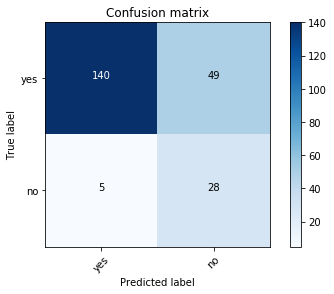

In [19]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["yes", "no"])
plt.show()


In [20]:
prob_classes_test_set = [classifier.prob_classify(document_features(cap, word_features)) for cap in test.captions]

In [21]:
test_y_binary = preprocessing.label_binarize(test.sponsored, classes = ['no','yes'])
test_y_binary = [y for x in test_y_binary for y in x]

In [22]:
prob_y_yes = [i.prob('yes') for i in prob_classes_test_set]

In [23]:
fpr, tpr, thresholds = roc_curve(test.sponsored, prob_y_yes, pos_label='yes')
roc_auc = auc(fpr, tpr)

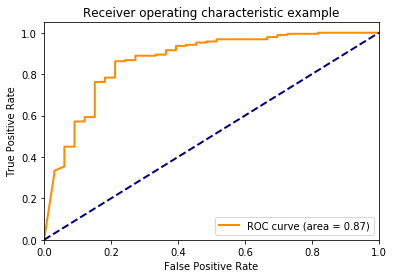

In [24]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# tf-idf featurization

In [2]:
youtube_data = pd.read_pickle("youtube_captions_scraped_filterChannels.pickle")

In [3]:
sum(np.array([i == 'no' for i in youtube_data.sponsored]))

375

In [4]:
sample_size = 300
not_spon = [index for index, item in enumerate(youtube_data.sponsored) if item == 'no']
not_spon_sample = random.sample(not_spon,sample_size)
spon = [index for index, item in enumerate(youtube_data.sponsored) if item == 'yes']
spon_sample = random.sample(spon,sample_size)

In [5]:
train = youtube_data.iloc[not_spon_sample + spon_sample, :]
print(len(train))
train.head()

600


,captions,sponsored,video_ids,channels
279,yeah got a new fish here cutting yeah cut end ...,no,PcZ2jNPqVKY,Thomas Arnold
287,hi guys it's a girl Chris and welcome back to ...,no,WgQb94UIi3E,krislumagui
310,everyone okay look at this in the way this is ...,no,HQts7Xv-Y7k,Wayne Goss
285,[Music] by little,no,phLQ4jCUfKI,YoItsPJO
398,The #notsponsored challenge is easy. Just laun...,no,rH8oKfJLP24,YEAY


In [6]:
spon_test =  list(set(spon) - set(spon_sample))
not_spon_test =  list(set(not_spon) - set(not_spon_sample))

In [7]:
len(spon_test), len(not_spon_test)

(141, 75)

In [8]:
sample_size_test = 75

not_spon_sample = random.sample(not_spon_test,sample_size_test)
spon_sample = random.sample(spon_test,sample_size_test)

test = youtube_data.iloc[not_spon_sample+ spon_sample, :]

In [9]:
len(test)

150

# TFIDF

In [75]:
ps = PorterStemmer()

def stem_tokens(tokens, ps):
    
    #remove numbers
    tokens = [token for token in tokens if token.isalpha()]
    #print(len(tokens))
    
    
    #remove stop words
    stop = stopwords.words('english') + list(string.punctuation)
    tokens = [token for token in tokens if token not in stop]
    #print(len(tokens))
    
    
    # stem
    stemmed = []
    for item in tokens:
        stemmed.append(ps.stem(item))
    return stemmed

def stemmedCaption(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, ps)
    return ' '.join(stems)


In [103]:
stemmed = [stemmedCaption(i) for i in train.captions]

In [104]:
stemmed[2]

'everyon okay look way skincar routin lot ask decid film everyth seen video exact skincar routin mine therefor result get base upon product use skin differ bear mind put link product descript bar plu cheaper altern let make start cleanser first cleanser use polish choic clear pour normal cleanser one like realli nice skin still get breakout despit flatman approach soon still get breakout cleanser like strict skin irrit everi day twice day tote skin oh way noth video alway sponsor paid sent stuff know okay toner use twice day paula choic skin balanc cleanser normal oili combin skin twice day morn night use go see lot paula choic reason use year alway favorit love compani love product alway skin problemat paula choic good exfoli twice day chemic scrub rub skin irrit caus breakout bump morn even depend feel use clear anti red solut one use extra strength night morn depend feel use resist new one use brand new use h resist advanc smooth altern bha aj one exfoli poor pha chain exfoli surfac

In [105]:
len(stemmed)

600

In [106]:
train['captions_stemmed'] = stemmed

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [115]:
feature_extraction = TfidfVectorizer(stop_words='english', lowercase = True)

In [116]:
feature_extraction

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [117]:
X_train = feature_extraction.fit_transform(train.captions_stemmed)

In [119]:
filename = 'feature_extraction.sav'
pickle.dump(feature_extraction, open(filename, 'wb'))

In [110]:
print(X_train.shape)

(600, 15690)


In [111]:
stemmed_test = [stemmedCaption(i) for i in test.captions]

In [112]:
X_test = feature_extraction.transform(stemmed_test)
print(X_test.shape)

(150, 15690)


In [120]:
Y_train = train.sponsored
Y_test = test.sponsored

In [121]:
##### yes = 1, no = 2
test_y_binary = preprocessing.label_binarize(test.sponsored, classes = ['no','yes'])
test_y_binary = [y for x in test_y_binary for y in x]
train_y_binary = preprocessing.label_binarize(train.sponsored, classes = ['no','yes'])
train_y_binary = [y for x in train_y_binary for y in x]

In [122]:
#print(list(zip(test_y_binary, Y_test)))
#print(list(zip(train_y_binary, Y_train)))

In [123]:
y_train = np.ravel(train_y_binary) ### yes = 1
y_test = np.ravel(test_y_binary)

## tf-idf SVM

In [124]:
# train classifier
clf = SVC(probability=True, kernel='linear')
clf.fit(X_train, Y_train)



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [125]:
filename = 'svc_classifier.sav'
pickle.dump(clf, open(filename, 'wb'))

In [90]:
# predict and evaluate predictions
predictions_prob = clf.predict_proba(X_test)
predictions_prob[:5]

array([[ 0.84225562,  0.15774438],
       [ 0.25908297,  0.74091703],
       [ 0.24068446,  0.75931554],
       [ 0.94681456,  0.05318544],
       [ 0.81898024,  0.18101976]])

In [144]:
# predict and evaluate predictions
predictions_prob = clf.predict_proba(X_test[1,:])
'%.2f' % (predictions_prob.ravel()[1] * 100)

'72.78'

In [91]:
clf.classes_

array(['no', 'yes'], dtype=object)

In [92]:
# predict and evaluate predictions
predictions = clf.predict(X_test)
list(zip(Y_test, predictions))[:5]

[('no', 'no'), ('no', 'yes'), ('no', 'yes'), ('no', 'no'), ('no', 'no')]

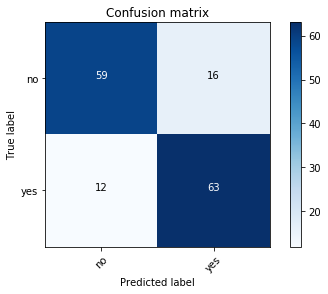

In [93]:
cnf_matrix = confusion_matrix(Y_test, predictions, labels = ['no','yes'])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['no','yes'])
plt.show()

In [94]:
len(predictions_prob )

150

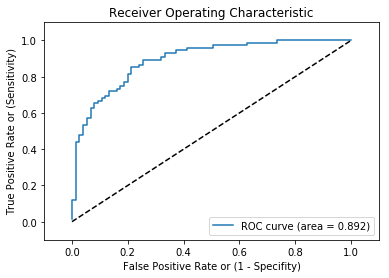

In [95]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(test_y_binary, predictions_prob[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [1]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = clf.coef_.toarray().ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(0, 1 + 2 * top_features-1), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

plot_coefficients(clf, feature_extraction.get_feature_names(), top_features = 25)

NameError: name 'clf' is not defined

In [98]:
clf.predict(X_test[0,:])[0]

'no'

In [30]:
feature_extraction_transform

<bound method TfidfVectorizer.fit_transform of TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize at 0x1a0a9a6c80>, use_idf=True,
        vocabulary=None)>

## tf-idf Naive Bayes

In [119]:
bernNB = BernoulliNB()
gausNB = GaussianNB()

bernNB.fit(X_train.toarray(), Y_train)
gausNB.fit(X_train.toarray(), Y_train)

GaussianNB(priors=None)

In [120]:
predictions_prob_bNB = bernNB.predict_proba(X_test)
predictions_bNB = bernNB.predict(X_test)
print(list(zip(Y_test,predictions_prob_bNB[:,1].round(3), predictions_bNB))[:5])

[('no', 0.0, 'no'), ('no', 0.0, 'no'), ('no', 0.0, 'no'), ('no', 0.0, 'no'), ('no', 0.0, 'no')]


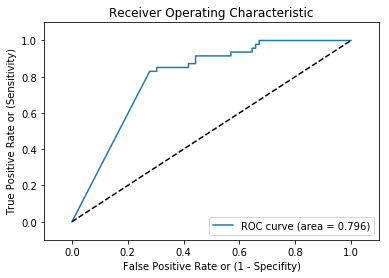

In [121]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(test_y_binary, predictions_prob_bNB[:,1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

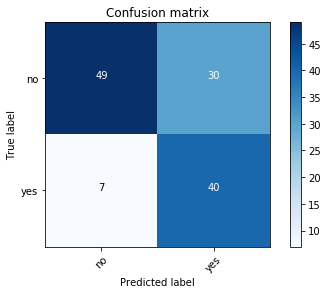

In [122]:
cnf_matrix = confusion_matrix(Y_test, predictions_bNB, labels = ['no','yes'])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['no','yes'])
plt.show()

In [123]:
predictions_prob_gNB = gausNB.predict_proba(X_test.toarray())
predictions_gNB = gausNB.predict(X_test.toarray())
print(list(zip(Y_test,predictions_prob_gNB[:,1], predictions_gNB))[:5])

[('no', 0.0, 'no'), ('no', 0.0, 'no'), ('no', 0.0, 'no'), ('no', 0.0, 'no'), ('no', 0.0, 'no')]


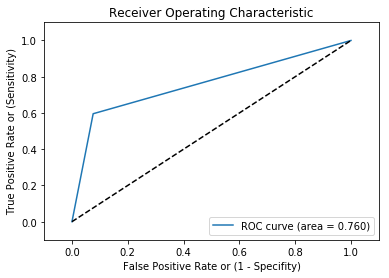

In [124]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(Y_test, predictions_prob_gNB[:,1], pos_label='yes')
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

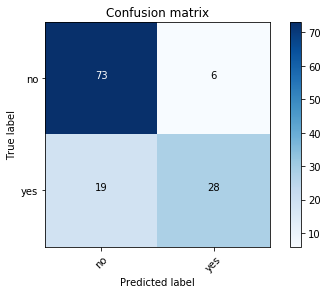

In [125]:
cnf_matrix = confusion_matrix(Y_test, predictions_gNB, labels = ['no','yes'])
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['no','yes'])
plt.show()